# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [245]:
# Import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.metrics import r2_score
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
import datetime
% matplotlib inline


In [204]:
#Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data EDA

In [205]:
portfolio.head(3)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


In [206]:
profile.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [207]:
transcript.head(3)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


## Null Values Exploration 

In [138]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [139]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [140]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

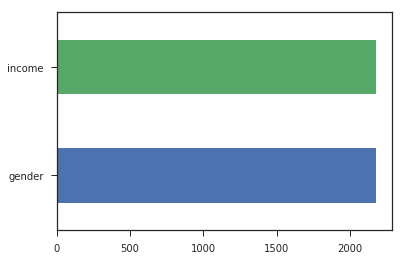

In [141]:
# # Visualization of null values where founded on Profile column 
profile.isna().sum().iloc[profile.isna().sum().nonzero()[0]].plot(kind='barh')

In [142]:
# Going through each column to detect the unique values 
print(np.sort(portfolio['offer_type'].unique()))
print((portfolio['channels']))
print(np.sort(portfolio['difficulty'].unique()))
print(np.sort(portfolio['duration'].unique()))
print(np.sort(portfolio['reward'].unique()))
print(np.sort(portfolio['id'].unique()))

['bogo' 'discount' 'informational']
0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object
[ 0  5  7 10 20]
[ 3  4  5  7 10]
[ 0  2  3  5 10]
['0b1e1539f2cc45b7b9fa7c272da2e1d7' '2298d6c36e964ae4a3e7e9706d1fb8c2'
 '2906b810c7d4411798c6938adc9daaa5' '3f207df678b143eea3cee63160fa8bed'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' '5a8bc65990b245e5a138643cd4eb9837'
 '9b98b8c7a33c4b65b9aebfe6a799e6d9' 'ae264e3637204a6fb9bb56bc8210ddfd'
 'f19421c1d4aa40978ebb69ca19b0e20d' 'fafdcd668e3743c1bb461111dcafc2a4']


In [143]:
print(profile['gender'].unique())


[None 'F' 'M' 'O']


In [144]:
print(transcript['event'].unique())
print(transcript['time'].unique())

['offer received' 'offer viewed' 'transaction' 'offer completed']
[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]


In [145]:
print(transcript['value'].values)

[{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
 {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
 {'offer id': '2906b810c7d4411798c6938adc9daaa5'} ..., {'amount': 3.61}
 {'amount': 3.5300000000000002} {'amount': 4.05}]


## Univariate Analysis

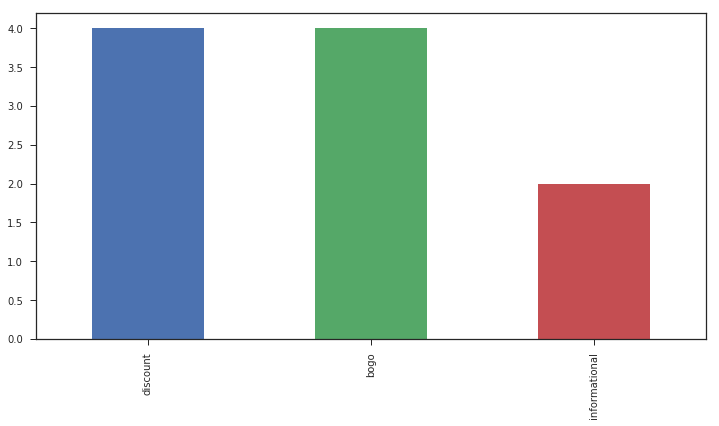

In [146]:
fig = plt.figure(figsize=(12,6))
portfolio['offer_type'].value_counts().plot(kind='bar')

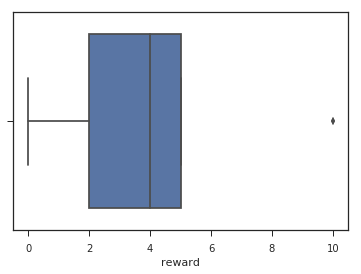

In [147]:
sns.boxplot(x=portfolio['reward'])

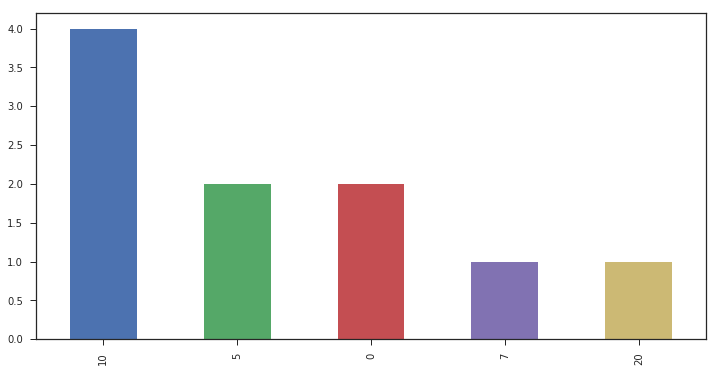

In [148]:
fig = plt.figure(figsize=(12,6))
portfolio['difficulty'].value_counts().plot(kind='bar')

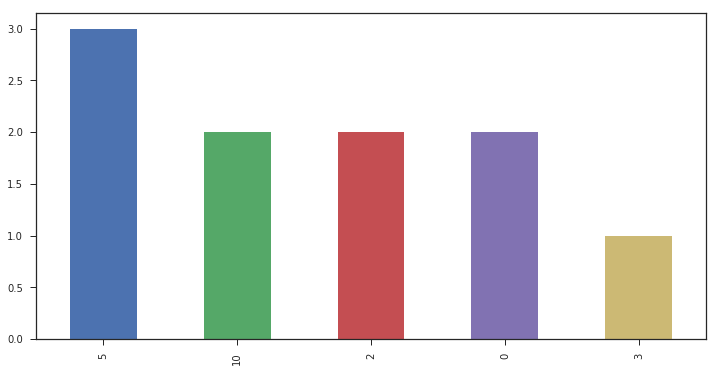

In [149]:
fig = plt.figure(figsize=(12,6))
portfolio['reward'].value_counts().plot(kind='bar')

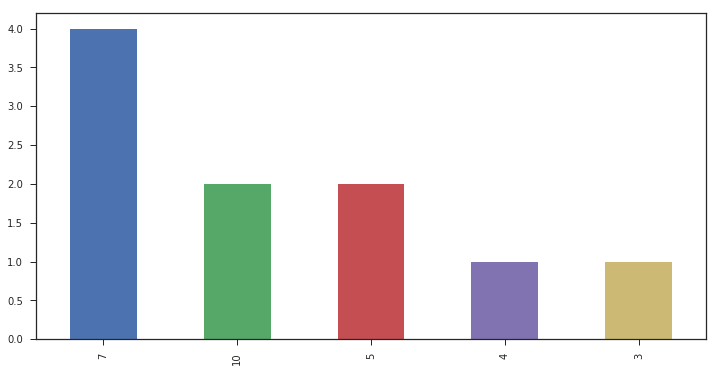

In [150]:
fig = plt.figure(figsize=(12,6))
portfolio['duration'].value_counts().plot(kind='bar')

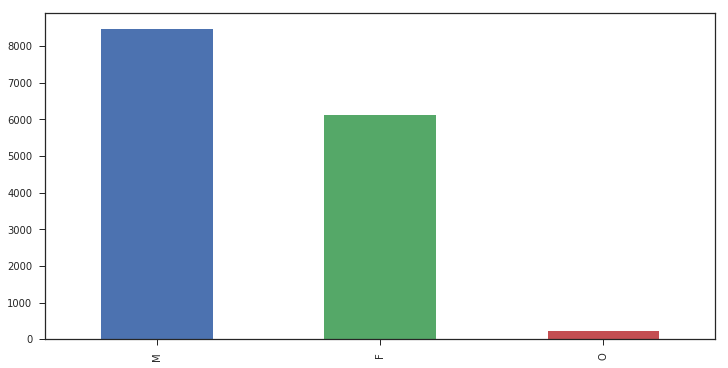

In [151]:
fig = plt.figure(figsize=(12,6))
profile['gender'].value_counts().plot(kind='bar')

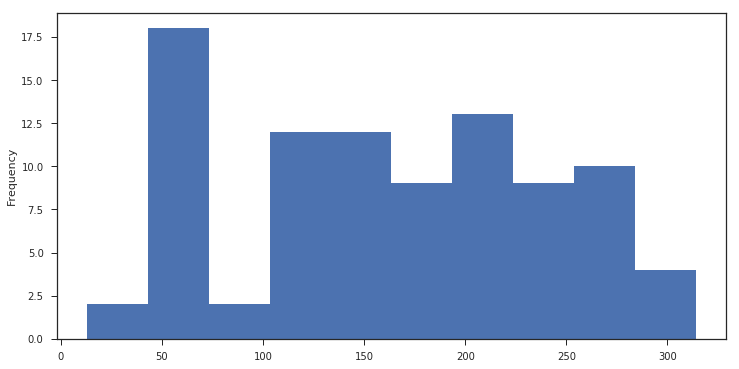

In [152]:
fig = plt.figure(figsize=(12,6))
profile['income'].value_counts().plot(kind='hist')

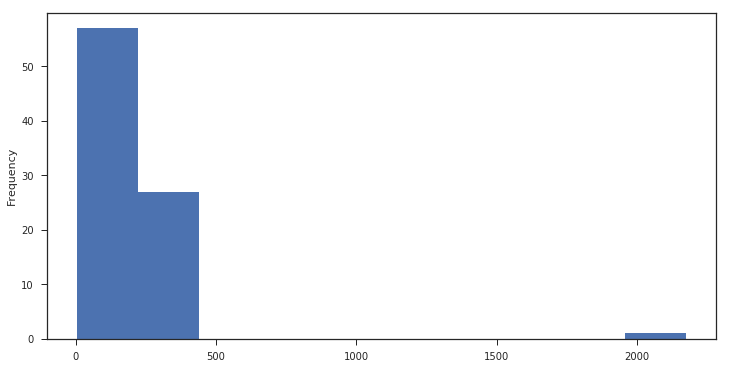

In [153]:
fig = plt.figure(figsize=(12,6))
profile['age'].value_counts().plot(kind='hist')

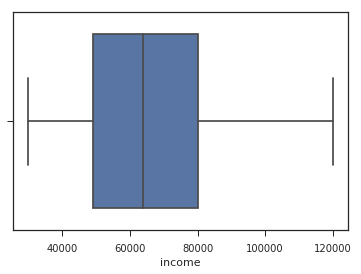

In [154]:
sns.boxplot(x=profile['income'])

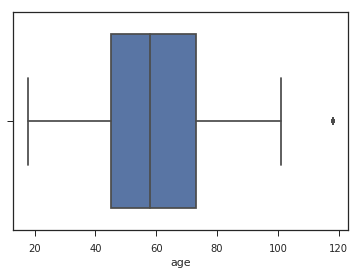

In [155]:
sns.boxplot(x=profile['age'])

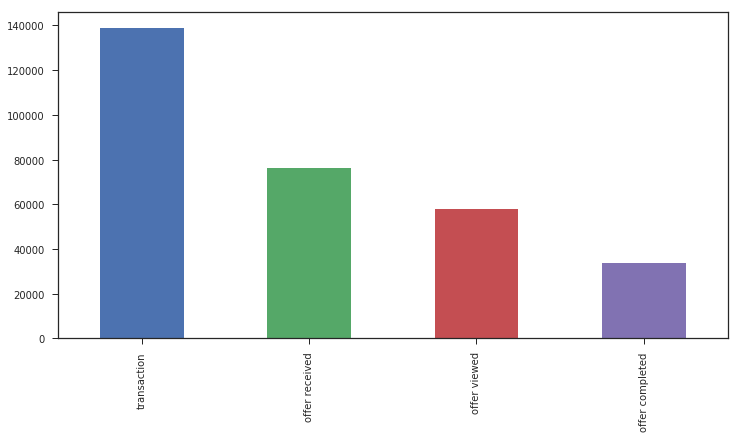

In [156]:
fig = plt.figure(figsize=(12,6))
transcript['event'].value_counts().plot(kind='bar')

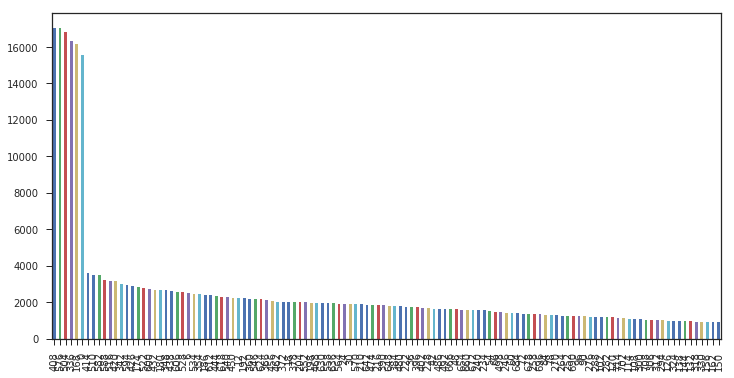

In [157]:
fig = plt.figure(figsize=(12,6))
transcript['time'].value_counts().plot(kind='bar')

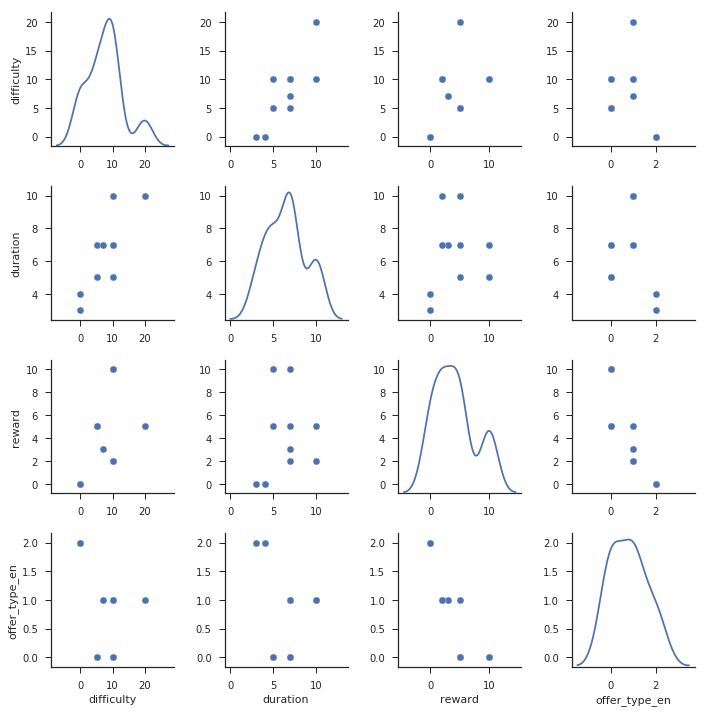

In [158]:
color_le = preprocessing.LabelEncoder()
color_le.fit(portfolio['offer_type'])
portfolio['offer_type_en'] = color_le.transform(portfolio['offer_type'])

_ = sns.pairplot(portfolio.drop('offer_type', axis=1), palette= 'muted', diag_kind='kde')

portfolio.drop('offer_type_en', axis=1, inplace= True)

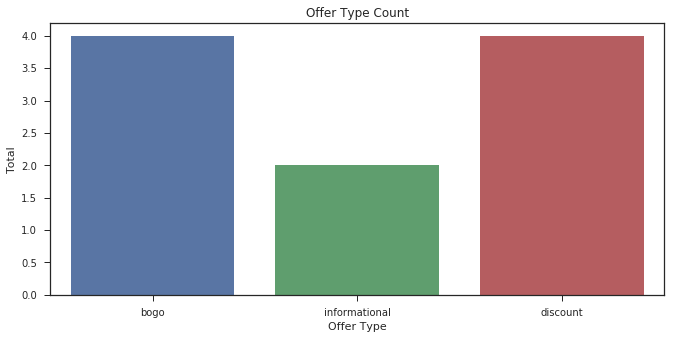

In [159]:
plt.figure(figsize=(11, 5))
g = sns.countplot(portfolio.offer_type)
plt.title('Offer Type Count')
plt.ylabel('Total')
plt.xlabel('Offer Type')
plt.xticks(rotation=0)
plt.show();

## Encode Categorical variables

In [160]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [208]:
def profile_column_preprocessing(df):
    '''
    This function will take a column and preprocess it starting from getting the dummy variables 
    ending with imputing the null values

    INPUT
    
    df = the profile column from the given data set 
    
    OUTPUT
    
    df column preprocessed 
    
    '''
    encoding_profile = pd.get_dummies(df['gender'])
    profile = pd.concat([encoding_profile, df] , axis=1)
    profile = profile.drop(['gender'], axis=1)
    profile['became_member_on'] = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")
    profile['start_year'] = profile['became_member_on'].dt.year
    profile["start_month"] = profile['became_member_on'].dt.month
    profile['age'].replace(118, np.nan, inplace=True)
    profile['income'].fillna(profile['income'].mean(), inplace=True)
    profile['age'].fillna(profile['age'].mean(), inplace=True)
    return profile

In [211]:
profile = profile_column_preprocessing(profile)
profile

,F,M,O,age,became_member_on,id,income,start_year,start_month
0,0,0,0,54.393524,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2
1,1,0,0,55.000000,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7
2,0,0,0,54.393524,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7
3,1,0,0,75.000000,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5
4,0,0,0,54.393524,2017-08-04,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8
5,0,1,0,68.000000,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.000000,2018,4
6,0,0,0,54.393524,2017-09-25,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568,2017,9
7,0,0,0,54.393524,2017-10-02,68617ca6246f4fbc85e91a2a49552598,65404.991568,2017,10
8,0,1,0,65.000000,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.000000,2018,2
9,0,0,0,54.393524,2016-11-22,8974fc5686fe429db53ddde067b88302,65404.991568,2016,11


## Transcript Column 

In [212]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [213]:
def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]

In [214]:
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

In [215]:
def transcript_column_preprocessing(df):
    '''
    This function will take a column and preprocess it starting from getting the dummy variables 
    ending with imputing the null values

    INPUT
    
    df = the transcript column from the given data set 
    
    OUTPUT
    
    df column preprocessed 
    
    '''
    encoding_transcript = pd.get_dummies(df['event'])
    transcript = pd.concat([encoding_transcript, df] , axis=1)
    transcript.rename(columns={'person': 'id'}, inplace=True)
    transcript.amount.astype(str)
    transcript['amount'].fillna(transcript['amount'].mean(), inplace=True)
    transcript.drop(columns=['value'], inplace=True)
    transcript = transcript[transcript.id.isin(profile['id'])]
    transcript = transcript.drop(['event'], axis=1)
    transcript['time'] = transcript['time'] / 24
    return transcript

In [216]:
transcript = transcript_column_preprocessing(transcript)
transcript

,offer completed,offer received,offer viewed,transaction,id,time,offer_id,amount
0,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,12.777356
1,0,1,0,0,a03223e636434f42ac4c3df47e8bac43,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,12.777356
2,0,1,0,0,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,12.777356
3,0,1,0,0,8ec6ce2a7e7949b1bf142def7d0e0586,0.00,fafdcd668e3743c1bb461111dcafc2a4,12.777356
4,0,1,0,0,68617ca6246f4fbc85e91a2a49552598,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,12.777356
5,0,1,0,0,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,12.777356
6,0,1,0,0,c4863c7985cf408faee930f111475da3,0.00,2298d6c36e964ae4a3e7e9706d1fb8c2,12.777356
7,0,1,0,0,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,12.777356
8,0,1,0,0,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,12.777356
9,0,1,0,0,31dda685af34476cad5bc968bdb01c53,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,12.777356


## Portfolio Column 

In [217]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [218]:
def portfolio_column_preprocessing(df):
    '''
    This function will take a column and preprocess it starting from getting the dummy variables 
    ending with imputing the null values

    INPUT
    
    df = the portfolio column from the given data set 
    
    OUTPUT
    
    df column preprocessed 
    
    '''
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in df.loc[index, 'channels']:
                df.loc[index, channel] = 1
            else:
                    df.loc[index, channel] = 0
    for index, row in df.iterrows():
        for offertype in ['bogo', 'informational', 'discount']:
            if offertype in df.loc[index, 'offer_type']:
                df.loc[index, offertype] = 1
            else:
                df.loc[index, offertype] = 0
    df.drop(columns='offer_type', inplace=True)
    df.drop(columns='channels', inplace=True)
    df.rename(columns={'id': 'offer_id'}, inplace=True)
    return df


In [219]:
portfolio = portfolio_column_preprocessing(portfolio)
portfolio

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1.0,1.0,0.0,1.0,0.0,0.0,1.0


## Further  Analysis

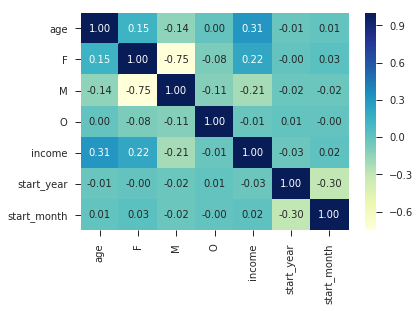

In [220]:
show_corr_profile = sns.heatmap(profile[['age','F','M','O', 'id','became_member_on', 'income','start_year','start_month']].corr(),annot = True ,fmt=".2f",cmap='YlGnBu')

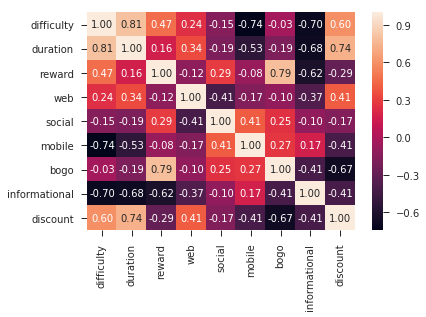

In [221]:
show_corr_portfolio = sns.heatmap(portfolio[['difficulty','duration','offer_id','reward', 'web', 'social','mobile','bogo','informational','discount']].corr(),annot = True ,fmt=".2f")

In [222]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 8 columns):
offer completed    306534 non-null uint8
offer received     306534 non-null uint8
offer viewed       306534 non-null uint8
transaction        306534 non-null uint8
id                 306534 non-null object
time               306534 non-null float64
offer_id           167581 non-null object
amount             306534 non-null float64
dtypes: float64(2), object(2), uint8(4)
memory usage: 12.9+ MB


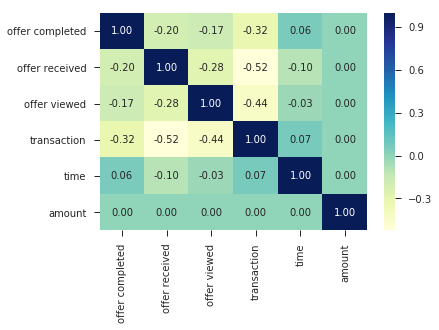

In [223]:
show_corr_transcript = sns.heatmap(transcript[['offer completed','offer received','offer viewed','transaction','time','id', 'offer_id','amount']].corr(),annot = True ,fmt=".2f",cmap='YlGnBu')

In [224]:
# Number of sent offers types
transcript['offer viewed'].sum(), transcript['offer completed'].sum(), transcript['offer received'].sum()

(57725, 33579, 76277)

## Merge Data 

In [225]:
first_merge = pd.merge(portfolio, transcript, on='offer_id')
first_merge.head(2)

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,informational,discount,offer completed,offer received,offer viewed,transaction,id,time,amount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,4b0da7e80e5945209a1fdddfe813dbe0,0.0,12.777356
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,1e9420836d554513ab90eba98552d0a9,0.0,12.777356


In [226]:
sec_merge = pd.merge(first_merge, profile, on='id')
sec_merge.head(2)

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,informational,...,time,amount,F,M,O,age,became_member_on,income,start_year,start_month
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,...,0.00,12.777356,0,1,0,64.0,2017-09-09,100000.0,2017,9
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,...,4.25,12.777356,0,1,0,64.0,2017-09-09,100000.0,2017,9


In [227]:
sec_merge.columns

Index(['difficulty', 'duration', 'offer_id', 'reward', 'web', 'email',
       'social', 'mobile', 'bogo', 'informational', 'discount',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'id', 'time', 'amount', 'F', 'M', 'O', 'age', 'became_member_on',
       'income', 'start_year', 'start_month'],
      dtype='object')

In [228]:
sec_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 26 columns):
difficulty          167581 non-null int64
duration            167581 non-null int64
offer_id            167581 non-null object
reward              167581 non-null int64
web                 167581 non-null float64
email               167581 non-null float64
social              167581 non-null float64
mobile              167581 non-null float64
bogo                167581 non-null float64
informational       167581 non-null float64
discount            167581 non-null float64
offer completed     167581 non-null uint8
offer received      167581 non-null uint8
offer viewed        167581 non-null uint8
transaction         167581 non-null uint8
id                  167581 non-null object
time                167581 non-null float64
amount              167581 non-null float64
F                   167581 non-null uint8
M                   167581 non-null uint8
O                   167581 no

## Normalize Numerical Features

In [229]:
scaler = RobustScaler()
numerical = ['age', 'start_year',
             'start_month','amount',
             'time','difficulty',
             'duration','reward']

sec_merge[numerical] = scaler.fit_transform(sec_merge[numerical])

# Show an example of a record with scaling applied
display(sec_merge.head(n = 1))


,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,informational,...,time,amount,F,M,O,age,became_member_on,income,start_year,start_month
0,0.0,0.0,ae264e3637204a6fb9bb56bc8210ddfd,1.666667,0.0,1.0,1.0,1.0,1.0,0.0,...,-1.192982,0.0,0,1,0,0.480324,2017-09-09,100000.0,0.0,0.333333


In [230]:
income = income.astype('int')
print(income.dtype)

int64


In [231]:
# Getting the target column 
income = sec_merge['income'].astype('int')
df = sec_merge.drop(['income','became_member_on','offer_id','id'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(df, income, test_size=0.2, random_state=1)

In [232]:
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 134064 samples.
Testing set has 33517 samples.


In [233]:
display(df.head(n = 3))

,difficulty,duration,reward,web,email,social,mobile,bogo,informational,discount,...,offer viewed,transaction,time,amount,F,M,O,age,start_year,start_month
0,0.0,0.0,1.666667,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,-1.192982,0.0,0,1,0,0.480324,0.0,0.333333
1,0.0,0.0,1.666667,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,0,-0.894737,0.0,0,1,0,0.480324,0.0,0.333333
2,0.0,0.0,1.666667,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0.280702,0.0,0,1,0,0.480324,0.0,0.333333


In [234]:
# Change the Label from continous into integer 
income = income.astype('int')
print(income.dtype)

int64


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 22 columns):
difficulty         167581 non-null float64
duration           167581 non-null float64
reward             167581 non-null float64
web                167581 non-null float64
email              167581 non-null float64
social             167581 non-null float64
mobile             167581 non-null float64
bogo               167581 non-null float64
informational      167581 non-null float64
discount           167581 non-null float64
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
transaction        167581 non-null uint8
time               167581 non-null float64
amount             167581 non-null float64
F                  167581 non-null uint8
M                  167581 non-null uint8
O                  167581 non-null uint8
age                167581 non-null float64
start_year         167581 non-null float64


# Model Building 

In [248]:
def show_accuracy(clf, X_train, X_test, y_train, y_test):
    '''
    This function will take calculate the accuracy between the training and testing data

    INPUT
    
    clf = the classifier / model
    X_train, y_train = the training set
    y_train, y_test = the testing set
    
    OUTPUT
    
    The accuracy percentage for the training and testing sets
    
    
    ''' 
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print('The training accuracy is', train_accuracy*100)
    print('The test accuracy is', test_accuracy*100)

In [236]:
clf_A= LogisticRegression(random_state=42).fit(X_train, y_train)

In [237]:
clf_A

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [239]:
show_accuracy(clf_A, X_train, X_test, y_train, y_test) 

The training accuracy is 13.6173767753
The test accuracy is 13.2529761017


In [240]:
clf_B = RandomForestClassifier().fit(X_train, y_train)

In [241]:
clf_B

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [242]:
show_accuracy(clf_B, X_train, X_test, y_train, y_test) 

The training accuracy is 94.4280343716
The test accuracy is 17.5135006116


In [246]:
clf_C = DecisionTreeClassifier().fit(X_train, y_train)

In [247]:
show_accuracy(clf_C, X_train, X_test, y_train, y_test) 

The training accuracy is 95.8713748657
The test accuracy is 66.6050064147


# Conclusion 

In conclusion, the varieties of the accuracy percentages between training sets and test sets and among different machine Learning models, as shown above, Decision Tree Classifier has showed the best accuracy percentages.